# CS5841 Transfer Learning and Augmentation
## Wei Qian

This project continues the Keras tutorial project on the Fashion-MNIST dataset to explore transfer learning and augmentation.

##  Part 1 Augmentation
Augmentation is a technical way to artificially create new training data from existing training data. This can be done by applying domain-specific techniques to examples from the training data that create new and different training examples. Image data augmentation involves creating transformed versions of images in the training dataset that belong to the same class as the original image. Transforms include a range of operations from the field of image manipulation, such as whitening, shifts, flips, rotation, zooms, and so on. Augmentation can help deep networks generalize for better testing error performance.

Keras neural network library provides the capability to fit models using image data augmentation by the ImageDataGenerator class and with many different image manipulations. To achive the image processing from Keras, we can follow these steps:

 - Import ImageDataGenerator from keras.preprocessing.image
 - Create image data generator and define specific augmentation techniques for image data
 - Fit the traning data to perform the transforms
 - Get the batches of augmented images
 
Then, we can apply augmentation on the Fashion-MNIST dataset using this Keras ImageDataGenerator class.

In [1]:
# imports for numpy handling and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import struct

# imports for keras image processing
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


First, we still need to load the dataset. Decode the ubyte image data to the numpy array, read the file information and decode the image file into pixel data, label file into real number.

In [2]:
def decode_idx3_ubyte(filename):
    bin_data = open(filename, 'rb').read()
    # decode header info
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    #print ('magic number:%d, image number: %d, image size: %d*%d' % (magic_number, num_images, num_rows, num_cols))
    # decode dataset
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images
 
def decode_idx1_ubyte(filename):
    bin_data = open(filename, 'rb').read()
    # decode header info
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    #print ('magic number:%d, image number: %d' % (magic_number, num_images))
    # decode dataset
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels

train_image = decode_idx3_ubyte('/train-images-idx3-ubyte')
print ('training image number: %d, image size: %d*%d' % (train_image.shape[0], train_image.shape[1], train_image.shape[2]))
train_label = decode_idx1_ubyte('/train-labels-idx1-ubyte')
print ('training label: %d' % (train_label.shape[0]))
test_image = decode_idx3_ubyte('/t10k-images-idx3-ubyte')
print ('test image number: %d, image size: %d*%d' % (test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_label = decode_idx1_ubyte('/t10k-labels-idx1-ubyte')
print ('test label: %d' % (test_label.shape[0]))

training image number: 60000, image size: 28*28
training label: 60000
test image number: 10000, image size: 28*28
test label: 10000


After we load the data, we can see the 60,000 images in training set and 10,000 images in test set, each image size is 28x28. Then, we can choose some expamles to compare the original images and the augmented images. We randomly choose ten different imgaes of the traning set in the ten classes, and each class has one image. 

In [0]:
labels=np.zeros(10)
samples=np.empty(10) # randomly show 10 samples
while True:
    rd=np.random.randint(len(train_label)) # random choice
    if labels[int(train_label[rd])]==0:
        samples[int(train_label[rd])]=rd
        labels[int(train_label[rd])]=1
    if np.count_nonzero(labels)==10:
        break

The original image is represented in grayscale, the background close to 0 and shape close to 255 pixel. Each label is a digit, representing to one category in the description table.

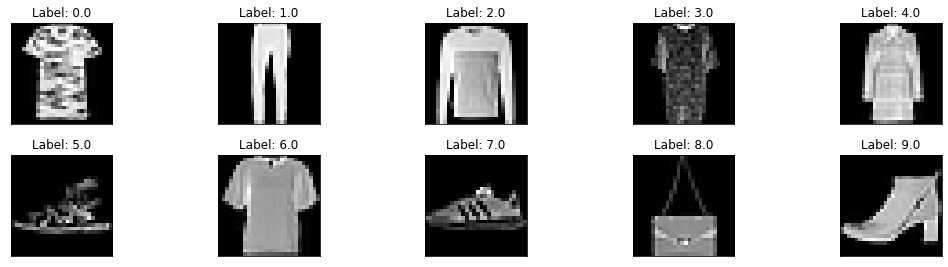

In [4]:
fig=plt.figure(figsize=(15,4))
for i in range(len(samples)):
    plt.subplot(2,5,i+1) # plot 10 images for 2 x 5
    plt.tight_layout()
    plt.imshow(train_image[int(samples[i])],cmap='gray') # show image
    plt.title("Label: {}".format(train_label[int(samples[i])])) # show label
    plt.xticks([])
    plt.yticks([])


<table style="float:left">
  <tr>
    <th>Label</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
  <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
  <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
  <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
  <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
  <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

### 1) ZCA Whitening
Whitening transformation is a linear transformation that transforms a vector of random variables with a known covariance matrix into a set of new variables whose covariance is the identity matrix, meaning that they are uncorrelated and each have variance 1.

Image whitening is a process of reducing the image to white noise vector, it is intended to better highlight the structures and features in the image to the learning algorithm.

We can perfom ZCA whitening by setting the zca_whitening argument to True in the ImageDataGenerator class. Then we can fit the traning data into that generator. We also need to expand one dimension for the traning data since this case is grayscale data, the channels axis of the image array should have value 1.

Flow() function takes the traing data and labels to generate batches of augmented data. We set batch size of 10 here, which means the generator takes every 10 images of the traning data to process. The return of flow() function is an iterator yielding tuples of (x, y) where x is a numpy array of image data and y is a numpy array of corresponding labels. Thus, we can follow the index to show the same samples and compare the results with the original images. 

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


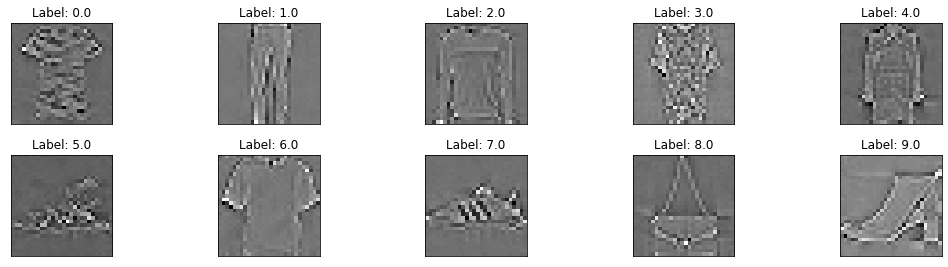

In [5]:
# need one channel dimension
x_train = train_image.reshape(train_image.shape[0],28,28,1)
x_test = test_image.reshape(test_image.shape[0],28,28,1)
# deifne ImageDataGenerator class
datagen=ImageDataGenerator(zca_whitening=True)
# fit traning data
datagen.fit(x_train)
# get batches of images from data generator, (x,y) tuples
batch=datagen.flow(x_train, train_label, batch_size=10, shuffle=False)
# use the same samples
fig=plt.figure(figsize=(15,4))
for i in range(len(samples)):
    plt.subplot(2,5,i+1) # plot 10 images for 2 x 5
    plt.tight_layout()
    plt.imshow(batch[int(samples[i])//10][0][int(samples[i])%10].reshape(28,28),cmap='gray') # show image in the batch
    plt.title("Label: {}".format(batch[int(samples[i])//10][1][int(samples[i])%10])) # show label in the batch
    plt.xticks([])
    plt.yticks([])

However, running the same samples with ZCA Whiting, we can see that theses images have the same general shapes with the original but the outline of each object has been highlighted.

### 2) Random Rotation
Rotation augmentation randomly rotates the image in a given number of degrees. The rotation will likely rotate pixels out of the image frame and leave areas of the frame with no pixel data that must be filled in.

We can perfom rotation by setting the rotation argument to a degree in the ImageDataGenerator class, then the generator will rotate the image between 0 to that degree.

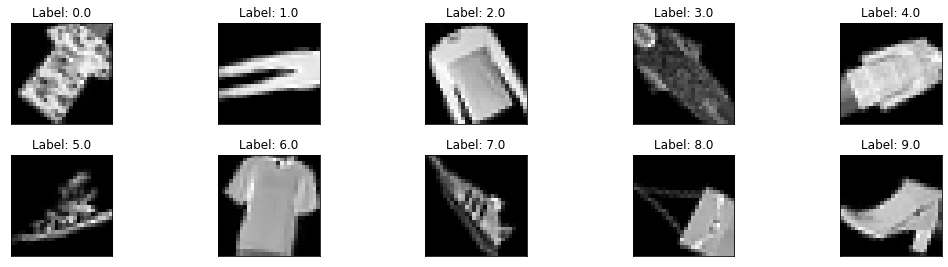

In [6]:
# need one channel dimension
x_train = train_image.reshape(train_image.shape[0],28,28,1)
x_test = test_image.reshape(test_image.shape[0],28,28,1)
# deifne ImageDataGenerator class
datagen=ImageDataGenerator(rotation_range=90)
# fit traning data
datagen.fit(x_train)
# get batches of images from data generator, (x,y) tuples
batch=datagen.flow(x_train, train_label, batch_size=10, shuffle=False)
# use the same samples
fig=plt.figure(figsize=(15,4))
for i in range(len(samples)):
    plt.subplot(2,5,i+1) # plot 10 images for 2 x 5
    plt.tight_layout()
    plt.imshow(batch[int(samples[i])//10][0][int(samples[i])%10].reshape(28,28),cmap='gray') # show image in the batch
    plt.title("Label: {}".format(batch[int(samples[i])//10][1][int(samples[i])%10])) # show label in the batch
    plt.xticks([])
    plt.yticks([])

Running the same samples, we can find that the all the images have been rotated, some rotate left to up 90 degree, some rotate right up to 90 degree.

### 3) Random Shifts
Originally, all the objects are in the center in the image frame. Shift agumentation can move the object horizontally and vertically. Actually, it is moving all pixels of the object in one direction. 

We can perform shift by setting the rate of width_shift_range and height_shift_range in the ImageDataGenerator class. The rate is a float that is the fraction of total width and total hight.

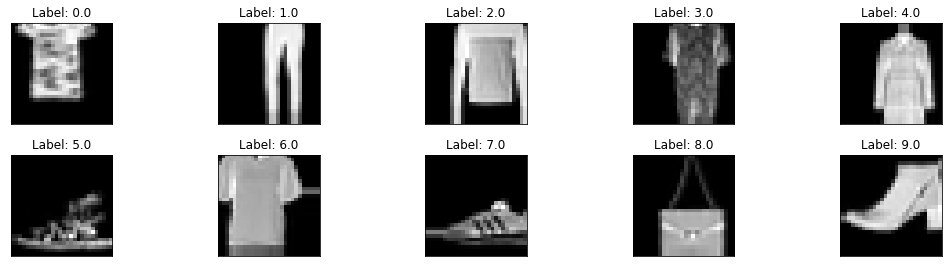

In [7]:
# need one channel dimension
x_train = train_image.reshape(train_image.shape[0],28,28,1)
x_test = test_image.reshape(test_image.shape[0],28,28,1)
# deifne ImageDataGenerator class
shift = 0.2
datagen=ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# fit traning data
datagen.fit(x_train)
# get batches of images from data generator, (x,y) tuples
batch=datagen.flow(x_train, train_label, batch_size=10, shuffle=False)
# use the same samples
fig=plt.figure(figsize=(15,4))
for i in range(len(samples)):
    plt.subplot(2,5,i+1) # plot 10 images for 2 x 5
    plt.tight_layout()
    plt.imshow(batch[int(samples[i])//10][0][int(samples[i])%10].reshape(28,28),cmap='gray') # show image in the batch
    plt.title("Label: {}".format(batch[int(samples[i])//10][1][int(samples[i])%10])) # show label in the batch
    plt.xticks([])
    plt.yticks([])

Running the same samples, we can see that the objects move left or right at a limit of 20%, or move up or down at a limte of 20%.

### 4) Random Flips
Image flip means reversing the rows or columns of pixels in the case of a vertical or horizontal flip respectively.

We can perform horizontal filp by setting the horizontal_flip to be Ture and we can also perform vertical flip by setting the vertiacal_flip to be True in the ImageDataGenerator.

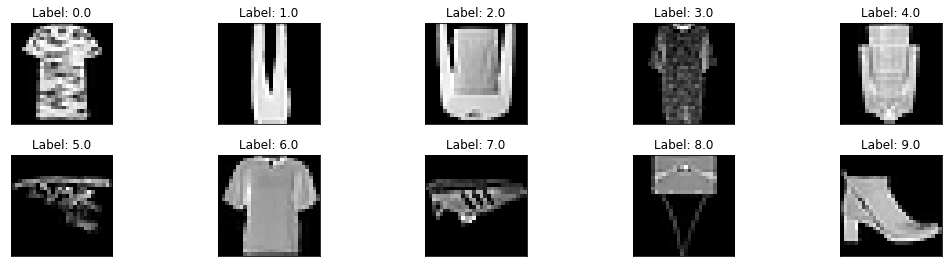

In [8]:
# need one channel dimension
x_train = train_image.reshape(train_image.shape[0],28,28,1)
x_test = test_image.reshape(test_image.shape[0],28,28,1)
# deifne ImageDataGenerator class
datagen=ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# fit traning data
datagen.fit(x_train)
# get batches of images from data generator, (x,y) tuples
batch=datagen.flow(x_train, train_label, batch_size=10, shuffle=False)
# use the same samples
fig=plt.figure(figsize=(15,4))
for i in range(len(samples)):
    plt.subplot(2,5,i+1) # plot 10 images for 2 x 5
    plt.tight_layout()
    plt.imshow(batch[int(samples[i])//10][0][int(samples[i])%10].reshape(28,28),cmap='gray') # show image in the batch
    plt.title("Label: {}".format(batch[int(samples[i])//10][1][int(samples[i])%10])) # show label in the batch
    plt.xticks([])
    plt.yticks([])

Running the same samples, we can see that the filp is random, some did not flip, some horizontal flipped, some vertically flipped, some both horizontal and vertically flipped.

### 5) Random Zoom
Zoom augmentation zooms the image in and out, it either adds new pixel values around the image or interpolates pixel values respectively.

We can perform the zoom by setting the rate of zoom_range in the ImageDataGenerator class. The rate means that the image will zoom between 1-rate (in) and 1+rate (out).

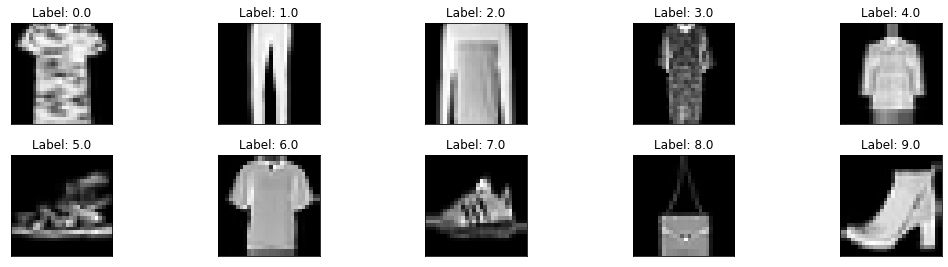

In [9]:
# need one channel dimension
x_train = train_image.reshape(train_image.shape[0],28,28,1)
x_test = test_image.reshape(test_image.shape[0],28,28,1)
# deifne ImageDataGenerator class
datagen=ImageDataGenerator(zoom_range=0.3)
# fit traning data
datagen.fit(x_train)
# get batches of images from data generator, (x,y) tuples
batch=datagen.flow(x_train, train_label, batch_size=10, shuffle=False)
# use the same samples
fig=plt.figure(figsize=(15,4))
for i in range(len(samples)):
    plt.subplot(2,5,i+1) # plot 10 images for 2 x 5
    plt.tight_layout()
    plt.imshow(batch[int(samples[i])//10][0][int(samples[i])%10].reshape(28,28),cmap='gray') # show image in the batch
    plt.title("Label: {}".format(batch[int(samples[i])//10][1][int(samples[i])%10])) # show label in the batch
    plt.xticks([])
    plt.yticks([])

Running the same samples, we can see that some images have been stretched in a limit of reate.

## Part 2 Transfer Learning

Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. Specifically, it is adapting knowledge from one domain to another. 

Transfer learning is an optimization that allows rapid progress or improved performance when modeling the second task. Transfer learning is the improvement of learning in a new task through the transfer of knowledge from a related task that has already been learned.

To understand how transfer learning works and its performance, we can use Keras to look at this example on the Fashion-MNIST dataset.

In [0]:
from __future__ import print_function

import time
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In this example, we induct transfer learning in CNN. We seperate the dataset into two sub datasets, one with the first 5 classes, aonther with the last 5 classes. We also define the feature layers and the dense layers for traning.

We first train a simple convnet on the Fashion-MNIST dataset the first 5 classes [0..4]. Then we freeze convolutional layers and fine-tune dense layers for the classification of the clases [5..9].

In [11]:
batch_size=128
num_classes=5
epochs=5

# convolutional filters
filters=32
# max pooling area
pool_size=2
# convolutional kernel size
kernel_size=3

if K.image_data_format() == 'channels_first':
    input_shape = (1, 28, 28) # image size
else:
    input_shape = (28, 28, 1)
    
def train_model(model, train, test, num_classes):
    x_train=train[0].reshape((train[0].shape[0],)+input_shape)
    x_test=test[0].reshape((test[0].shape[0],)+input_shape)
    x_train/=255 # normalization
    x_test/=255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # convert class vectors to binary class matrices
    y_train=keras.utils.to_categorical(train[1],num_classes)
    y_test=keras.utils.to_categorical(test[1],num_classes)
    
    t=time.time()
    model.compile(loss="categorical_crossentropy",optimizer="adadelta",metrics=["accuracy"])
    model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test,y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Training time: %s" % (time.time()-t))
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
x_train,y_train,x_test,y_test=train_image,train_label,test_image,test_label

# dataset A with classes 0-4, dataset B with classes 5-9
x_train_A=x_train[y_train<5]
y_train_A=y_train[y_train<5]
x_test_A=x_test[y_test<5]
y_test_A=y_test[y_test<5]

x_train_B=x_train[y_train>=5]
y_train_B=y_train[y_train>=5]-5 # transfer 5-9 to 0-4
x_test_B=x_test[y_test>=5]
y_test_B=y_test[y_test>=5]-5

# define feature layers and output layers
feature_layers=[Conv2D(filters,kernel_size,padding="valid",input_shape=input_shape),Activation("relu"),Conv2D(filters,kernel_size),Activation("relu"),MaxPooling2D(pool_size=pool_size),Dropout(0.25),Flatten()]
output_layers=[Dense(128),Activation("relu"),Dropout(0.5),Dense(num_classes),Activation("softmax")]

# create complete model
model=Sequential(feature_layers+output_layers)
# train model with dataset A
train_model(model,(x_train_A,y_train_A),(x_test_A,y_test_A),num_classes)
# freeze feature layers and rebuild model
for l in feature_layers:
    l.trainable=False
print('\n')
# transfer train ouput layers for dateset B
train_model(model,(x_train_B,y_train_B),(x_test_B,y_test_B),num_classes)

x_train shape: (30000, 28, 28, 1)
30000 train samples
5000 test samples
Train on 30000 samples, validate on 5000 samples
Epoch 1/5
30000/30000 [==============================] - 5s 154us/step - loss: 0.4603 - accuracy: 0.8270 - val_loss: 0.2888 - val_accuracy: 0.8910
Epoch 2/5
30000/30000 [==============================] - 3s 107us/step - loss: 0.2964 - accuracy: 0.8947 - val_loss: 0.2835 - val_accuracy: 0.8886
Epoch 3/5
30000/30000 [==============================] - 3s 106us/step - loss: 0.2532 - accuracy: 0.9103 - val_loss: 0.2421 - val_accuracy: 0.9154
Epoch 4/5
30000/30000 [==============================] - 3s 105us/step - loss: 0.2272 - accuracy: 0.9207 - val_loss: 0.2180 - val_accuracy: 0.9208
Epoch 5/5
30000/30000 [==============================] - 3s 107us/step - loss: 0.2106 - accuracy: 0.9261 - val_loss: 0.2259 - val_accuracy: 0.9162
Training time: 18.67292046546936
Test loss: 0.225898174905777
Test accuracy: 0.9161999821662903


x_train shape: (30000, 28, 28, 1)
30000 train 

As we can see, the network trained on dataset A and transferred to dataset B. The second training time is  less than the first traning, and the second testing accuray is 97%, which is also higher than the first testing accuray. Thus, we can see that the transfer + fine tuning improves generalization.

---

Keras also provides many pre-trained applications that we can use for the Fashion-MNIST dataset. Here, we will use MobileNetV2 and VGG19 these two pre-trained network architecture as the feature layers to apply on our classification task.

### VGG19

In [0]:
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

First, we need to process the dataset. VGG19 requires the input of colored images, however, the Fashion-MNIST are black and white color. Thus, we need to convert the inmages into 3 colored channels R, G, B. We also need to reshape thr images into tensot format by Tensorflow which has 4 dimensions. In addition, the Fashion-MNIST image size is 28x28, while the VGG19 minimum required image size is 32x32, so we need to resize the image using keras image processing. The labels still need to be converted to binaty class metrices. 

In [13]:
input_shape=(48,48,3)
num_classes=10
batch_size=128
epochs=50

# add 3 channels to training and test images
x_train=np.dstack([train_image]*3)
x_test=np.dstack([test_image]*3)
x_train=x_train.reshape(-1,28,28,3)
x_test=x_test.reshape(-1,28,28,3)
x_train=x_train.astype("float32")
x_test=x_test.astype("float32")
print(x_train.shape,x_test.shape)

# resize image to 48x48 as VGG19 required
x_train=np.asarray([img_to_array(array_to_img(img,scale=False).resize((48,48))) for img in x_train])
x_test=np.asarray([img_to_array(array_to_img(img,scale=False).resize((48,48))) for img in x_test])
print(x_train.shape,x_test.shape)

# convert class vectors to binary class matrices
y_train=keras.utils.to_categorical(train_label,num_classes)
y_test=keras.utils.to_categorical(test_label,num_classes)

# normalization
x_train/=255
x_test/=255

(60000, 28, 28, 3) (10000, 28, 28, 3)
(60000, 48, 48, 3) (10000, 48, 48, 3)


Then, we can create the VGG19 model and show the detail architecture of the VGG19 convolutional base. Next, run the training data through feature layers and save the feature data, then train output layers from scratch using that saved feature data. 

In [14]:
# create base modle of VGG19
vgg19=VGG19(weights="imagenet",include_top=False,input_shape=input_shape,classes=num_classes)

# architecture
vgg19.summary()

# process input
vgg_19_x_train=preprocess_input(x_train)
vgg19_x_test=preprocess_input(x_test)

# extract features
vgg19_train_features=vgg19.predict(np.array(vgg_19_x_train),batch_size=batch_size,verbose=1)
vgg19_test_features=vgg19.predict(np.array(vgg19_x_test),batch_size=batch_size,verbose=1)

# save features
np.savez("VGG19_train_features",vgg19_train_features,y_train)
np.savez("VGG19_test_features",vgg19_test_features,y_test)
#print(train_features.shape,test_features.shape)

# flatten extracted features
vgg19_train_features=np.reshape(vgg19_train_features,(vgg_19_x_train.shape[0],1*1*512))
vgg19_test_features=np.reshape(vgg19_test_features,(vgg19_x_test.shape[0],1*1*512))
#print(train_features.shape,test_features.shape)

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

Look at the last layer of VGG19, the feature pool has shape(1,1,512). This is the feature that we need to build for our own ouput layer. We create the dense layer with the same input dimension from VGG19, and complie the model. I choose categorical_crossentropy as the loss function (which is relevent for multiclass, single-label classification problem) and Adam optimizer. 

Next, we can train the model with the batch size and epochs on both traning featues and test features we saved before.

In [15]:
# create model and drop top layers of VGG19
model=models.Sequential()
model.add(layers.Dense(512,activation="relu",input_dim=1*1*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10,activation="softmax"))

# complie the model
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

# train the model
history=model.fit(vgg19_train_features,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(vgg19_test_features,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 39us/step - loss: 2.2351 - accuracy: 0.2838 - val_loss: 1.6014 - val_accuracy: 0.4416
Epoch 2/50
60000/60000 [==============================] - 2s 37us/step - loss: 1.5256 - accuracy: 0.4398 - val_loss: 1.3708 - val_accuracy: 0.5375
Epoch 3/50
60000/60000 [==============================] - 2s 38us/step - loss: 1.3850 - accuracy: 0.5015 - val_loss: 1.2721 - val_accuracy: 0.5790
Epoch 4/50
60000/60000 [==============================] - 2s 41us/step - loss: 1.3006 - accuracy: 0.5358 - val_loss: 1.2405 - val_accuracy: 0.5459
Epoch 5/50
60000/60000 [==============================] - 3s 42us/step - loss: 1.2472 - accuracy: 0.5570 - val_loss: 1.1660 - val_accuracy: 0.5881
Epoch 6/50
60000/60000 [==============================] - 2s 38us/step - loss: 1.2096 - accuracy: 0.5724 - val_loss: 1.1156 - val_accuracy: 0.6173
Epoch 7/50
60000/60000 [==============================] - 2s 38us/st

We can also polt the traning and validation accuracy, loss along with the epochs. And give the final test score of the test data.

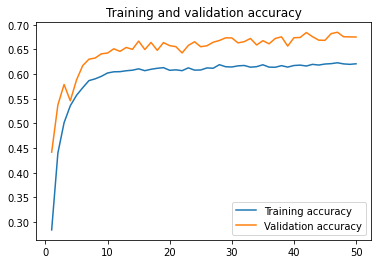

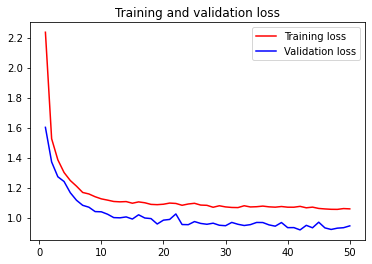

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_axis = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs_axis, acc, label='Training accuracy')
plt.plot(epochs_axis, val_acc, label='Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs_axis, loss, 'red', label='Training loss')
plt.plot(epochs_axis, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

In [17]:
vgg19_score=model.evaluate(vgg19_test_features,y_test,verbose=0)
print("Test loss:",vgg19_score[0])
print("Test accuracy:",vgg19_score[1])

Test loss: 0.9449318233489991
Test accuracy: 0.6753000020980835


The above two plots show the training and validatoin accuracy, loss. We can find that the traning and validatoin accuracy are all increaseing with the epochs. They are very fast especially in the interval of 0 to 10 epochs, then becomes very steady. The training and validation loss plots are similiar, both training loss and validation loss are decreasing with the epochs. Although the lines of loss and accuracy for both training and validation follow similar trends, there're some space between their values.

And we achive the test accuray of 67.5% using the VGG pre-trained model at this point.

After that, we can also combine feature layers and output layers into one network, freeze the feature layers, and additionally train the output layers using augmentation; and fine-tuning the full network.
 - Freeze the feature layers
 - Define our own ouput layers with 10 nodes, and the combine the input layers from VGG19.
 - Complie the final model with same parameters.
 - Initiate augumentation on training set
 - Initiate augumentation on test set
 - Fit the model with augumentated data (fine tuning)

In [0]:
# freeze the layers
for l in vgg19.layers[:5]:
    l.trainable=False
    
# add output layers to VGG19
pre=vgg19.output
pre=Flatten()(pre)
pre=Dense(512,activation="relu")(pre)
pre=Dropout(0.5)(pre)
pre=Dense(10,activation="softmax")(pre)

# create final model
vgg19_model_final=Model(inputs=[vgg19.input],outputs=pre)

# compile the model 
vgg19_model_final.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Initiate the training generator with data Augumentation 
train_datagen = ImageDataGenerator(
horizontal_flip = True,
zoom_range = 0.2,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=20)

# fits the model on batches with data augmentation
history=vgg19_model_final.fit_generator(train_datagen.flow(x_train, y_train),epochs=ephchs,validation_data=(x_test,y_test),verbose=0)

### MobileNetV2

Sceond, we use MobileNetV2 pre-trained network, a different feature layers but same process with VGG19. 

We create a MobileNetV2 model, show the configuration, process the same traning and test data, extract and save the features, then train output layers using that saved feature data, combine feature layers and output layers into one network, freeze the feature layers, additionally training the output layers using augmentation, and fine-tuning the full network at the end.

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 49, 49, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
________________

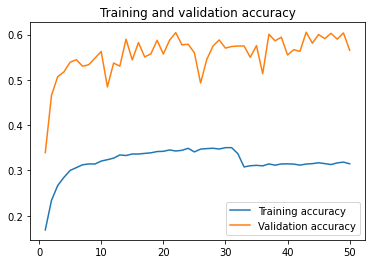

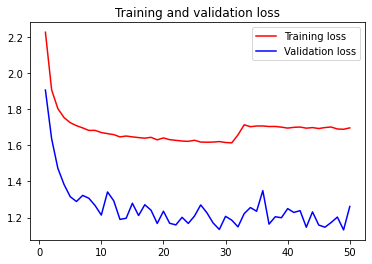

Test loss: 1.2613593837738037
Test accuracy: 0.5655999779701233


In [19]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# create base modle of MobileNet
mob=MobileNetV2(weights="imagenet",include_top=False,input_shape=input_shape,classes=num_classes)

# architecture
mob.summary()

# process input
mob_x_train=preprocess_input(x_train)
mob_x_test=preprocess_input(x_test)

# extract features
mob_train_features=mob.predict(np.array(mob_x_train),batch_size=batch_size,verbose=1)
mob_test_features=mob.predict(np.array(mob_x_test),batch_size=batch_size,verbose=1)

# save features
np.savez("MobileNetV2_train_features",mob_train_features,y_train)
np.savez("MobileNetV2_test_features",mob_test_features,y_test)
#print(train_features.shape,test_features.shape)

# flatten extracted features
mob_train_features=np.reshape(mob_train_features,(mob_x_train.shape[0],2*2*1280))
mob_test_features=np.reshape(mob_test_features,(mob_x_test.shape[0],2*2*1280))
#print(train_features.shape,test_features.shape)

# create model and drop top layers of MobileNetV2
model=models.Sequential()
model.add(layers.Dense(512,activation="relu",input_dim=2*2*1280))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10,activation="softmax"))

# complie the model
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

# train the model
history=model.fit(mob_train_features,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(mob_test_features,y_test))

# plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_axis = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs_axis, acc, label='Training accuracy')
plt.plot(epochs_axis, val_acc, label='Validation accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs_axis, loss, 'red', label='Training loss')
plt.plot(epochs_axis, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

# score
mob_score=model.evaluate(mob_test_features,y_test,verbose=0)
print("Test loss:",mob_score[0])
print("Test accuracy:",mob_score[1])

# freeze the layers
for l in mob.layers[:5]:
    l.trainable=False
    
# add output layers to Mobilenet
pre=mob.output
pre=Flatten()(pre)
pre=Dense(512,activation="relu")(pre)
pre=Dropout(0.5)(pre)
pre=Dense(10,activation="softmax")(pre)

# create final model
mob_model_final=Model(inputs=[mob.input],outputs=pre)

# compile the model 
mob_model_final.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Initiate the training generator with data Augumentation 
train_datagen = ImageDataGenerator(
horizontal_flip = True,
zoom_range = 0.2,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=20)

# fits the model on batches with data augmentation
history=mob_model_final.fit_generator(train_datagen.flow(x_train, y_train),epochs=epochs,validation_data=(x_test,y_test),verbose=0)

For the results of MobileNetV2, the above two plots show the training and validatoin accuracy, loss. We can find some same trends of traning, validation accuray and loss with VGG19. But we only achive the test accuray of 56.5% using the MobileNetV2 pre-trained model. The validation accuracy and loss are fluctuated.

### Summary

Now, we have experimented with two different feature layers (VGG19 and MobileNetV2), we can compare the structure,  the relative complexity, and the results of them.

VGG19 combined model diagram: 

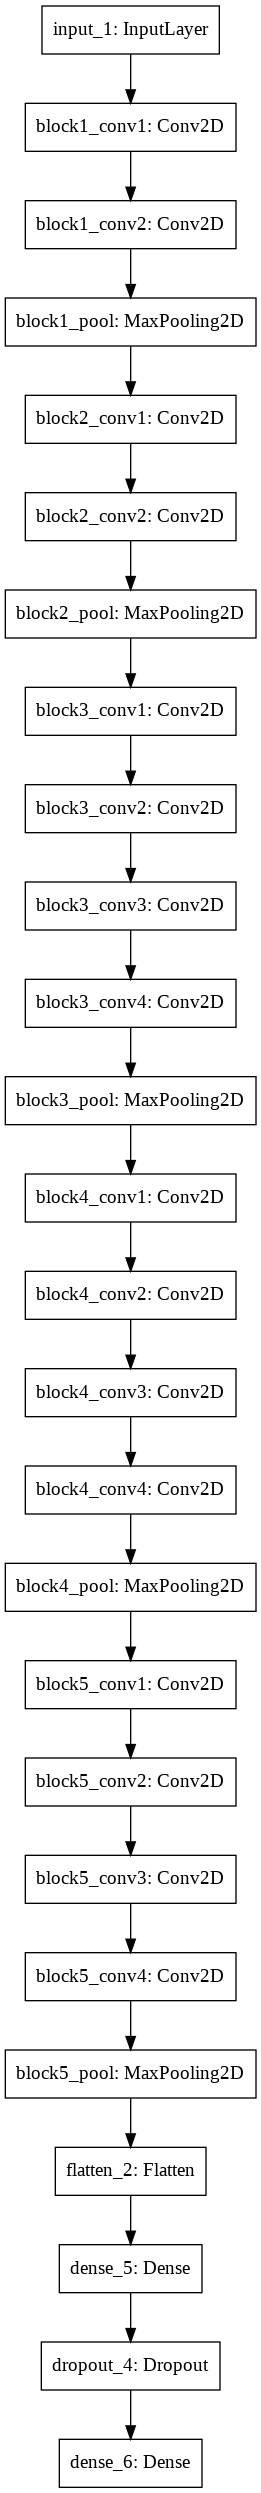

In [20]:
keras.utils.plot_model(vgg19_model_final, to_file='vgg19.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

MobileNetV2 combined model diagram:

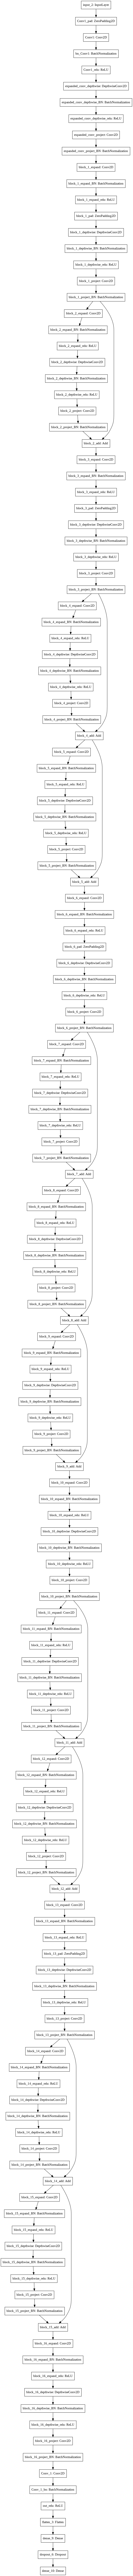

In [21]:
keras.utils.plot_model(mob_model_final, to_file='vgg19.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [22]:
layers=[len(vgg19_model_final.layers),len(mob_model_final.layers)]
params=[vgg19_model_final.count_params(),mob_model_final.count_params()]
losses=[np.round(vgg19_score[0],4),np.round(mob_score[0],4)]
accs=[np.round(vgg19_score[1],4),np.round(mob_score[1],4)]

df=pd.DataFrame({"Pre-Trained Network":["VGG19","MobileNetV2"],"Total Parameters":params,"Layers":layers,"Test Loss":losses,"Test Accuracy":accs})
print(df)

  Pre-Trained Network  Total Parameters  Layers  Test Loss  Test Accuracy
0               VGG19          20292170      26     0.9449         0.6753
1         MobileNetV2           4885066     159     1.2614         0.5656


From the above two diagrams and the table, we can first see that the structure of MobileNetV2 is more complicated than VGG19. MobileNetV2 has more layers and the some of layers are crossed. The layers of VGG19 are very strighforward, but VGG19 has more parameters. 

As the test results, VGG19 has 0.9449 loss and 0.6753 accuracy, however, MobileNetV2 has 1.2614 loss and 0.5656 accuracy. Obviously, VGG19 has better performance than MobileNetV2 on this Fashion-MNIST dataset.

In summary, we would like to say that VGG19 worked better for this Fashion-MNIST dataset since it has relative simple network and higer test accuracy. 